In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/shenzhen_consensus_roi.csv
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0499_1.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0120_0.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0192_0.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0548_1.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0119_0.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0403_1.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/ClinicalReadings/CHNCXR_0368_1.txt
/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhe

## Import Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
from tqdm import tqdm 

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# 1. EDA (Exploratory Data Analysis)

In [3]:
mont_image_list = os.listdir('/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Montgomery_Set/Montgomery_Set/CXR_png')
shen_image_list = os.listdir('/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/CXR_png')
print(len(mont_image_list))
print(len(shen_image_list))

138
662


In [4]:
# put the images into dataframes
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later

df_mont.reset_index(inplace=True, drop=True)
df_shen.reset_index(inplace=True, drop=True)

print(df_mont.shape)
print(df_shen.shape)

(138, 1)
(662, 1)


## 📌 Labels of The Images

In the **Montgomery** and **Shenzhen** datasets, the file names follow a specific format such as:

- **`MCUCXR_0108_1.png`**
- **`CHNCXR_00001_0.png`**

---

### 🔹 Label Meaning

The **last number** in the filename (`_0` or `_1`) indicates the label:

- **`_0` → 🟢 Normal**  
- **`_1` → 🔴 Tuberculosis (TB)**  

| **Example filename**    | **Last digit** | **Label**        |
|--------------------------|----------------|------------------|
| `CHNCXR_00001_0.png`    | 0              | 🟢 Normal        |
| `MCUCXR_0108_1.png`     | 1              | 🔴 Tuberculosis (TB)  |


In [5]:
def Label_Image(x):
    Label = int(x[-5])
    if Label == 0:
        return 'Normal'
    if Label == 1:
        return 'Tuberculosis(TB)'

# Assign the target labels
df_mont['Label'] = df_mont['image_id'].apply(Label_Image)
df_shen['Label'] = df_shen['image_id'].apply(Label_Image)

In [6]:
df_mont.head()

image_id             Label
0  MCUCXR_0017_0.png            Normal
1  MCUCXR_0020_0.png            Normal
2  MCUCXR_0030_0.png            Normal
3  MCUCXR_0013_0.png            Normal
4  MCUCXR_0354_1.png  Tuberculosis(TB)

In [7]:
df_shen.head()

image_id             Label
0  CHNCXR_0092_0.png            Normal
1  CHNCXR_0322_0.png            Normal
2  CHNCXR_0304_0.png            Normal
3  CHNCXR_0572_1.png  Tuberculosis(TB)
4  CHNCXR_0547_1.png  Tuberculosis(TB)

In [8]:
# Montgomery Dataset

df_mont['Label'].value_counts()

Label
Normal              80
Tuberculosis(TB)    58
Name: count, dtype: int64

In [9]:
# Shenzen Dataset

df_shen['Label'].value_counts()

Label
Tuberculosis(TB)    336
Normal              326
Name: count, dtype: int64

In [10]:

def show_random_images(df, col_name, n_cols, image_path):
    categories = df[col_name].unique()
    fig, axes = plt.subplots(len(categories), n_cols, figsize=(4*n_cols, 4*len(categories)))
    
    for i, category_name in enumerate(categories):
        sample = df[df[col_name]==category_name].sample(n_cols)
        for j, (index, row) in enumerate(sample.iterrows()):
            img = imageio.imread(f"{image_path}{row['image_id']}")
            axes[i][j].imshow(img, cmap='gray')
            axes[i][j].axis('off')
            axes[i][j].set_title(category_name)
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_19/4192730750.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f"{image_path}{row['image_id']}")


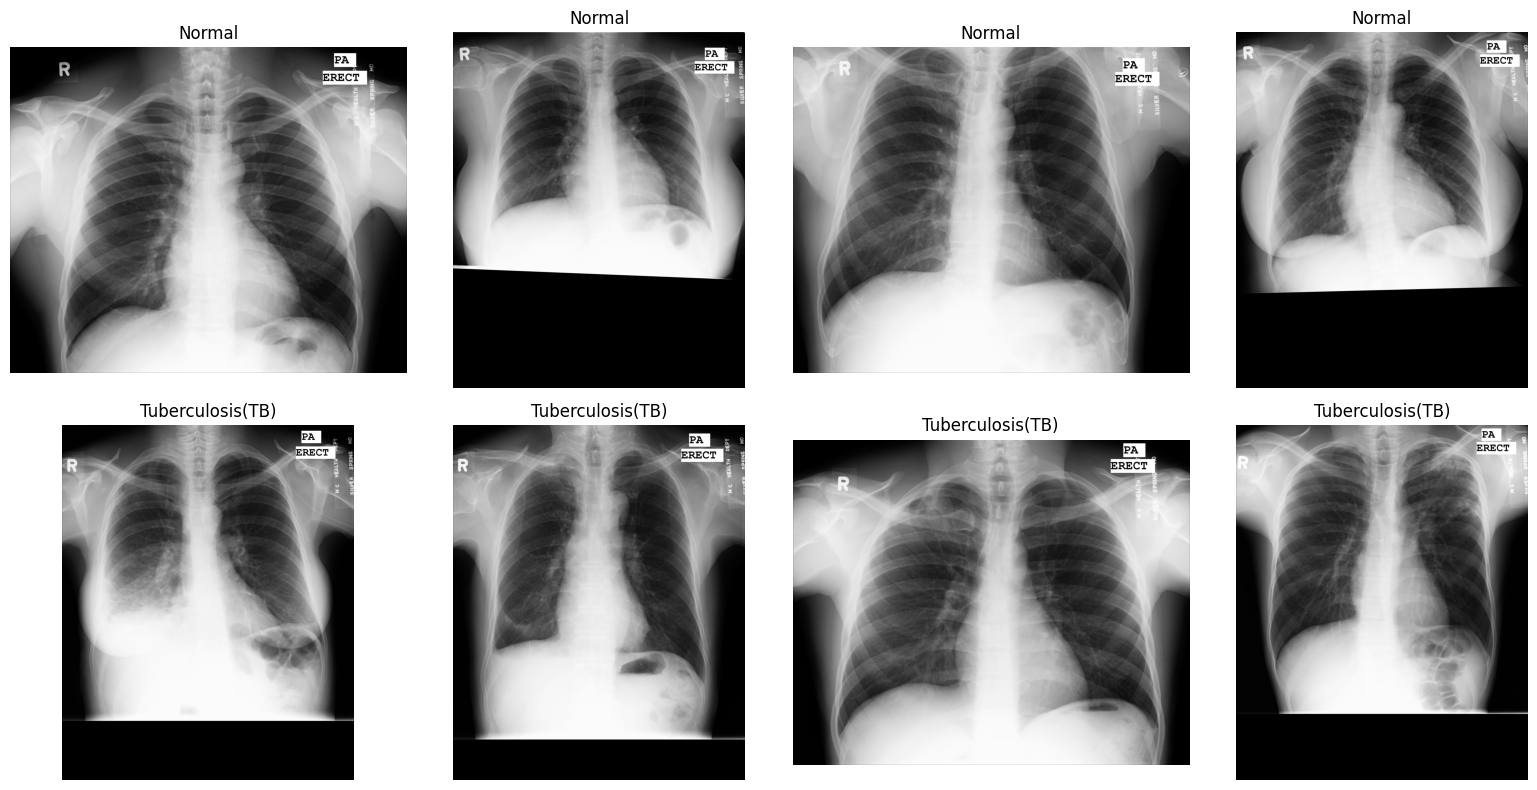

In [11]:
# Montgomery Dataset

image_path = '/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Montgomery_Set/Montgomery_Set/CXR_png/'
show_random_images(df_mont, 'Label', 4, image_path)

/tmp/ipykernel_19/4192730750.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f"{image_path}{row['image_id']}")


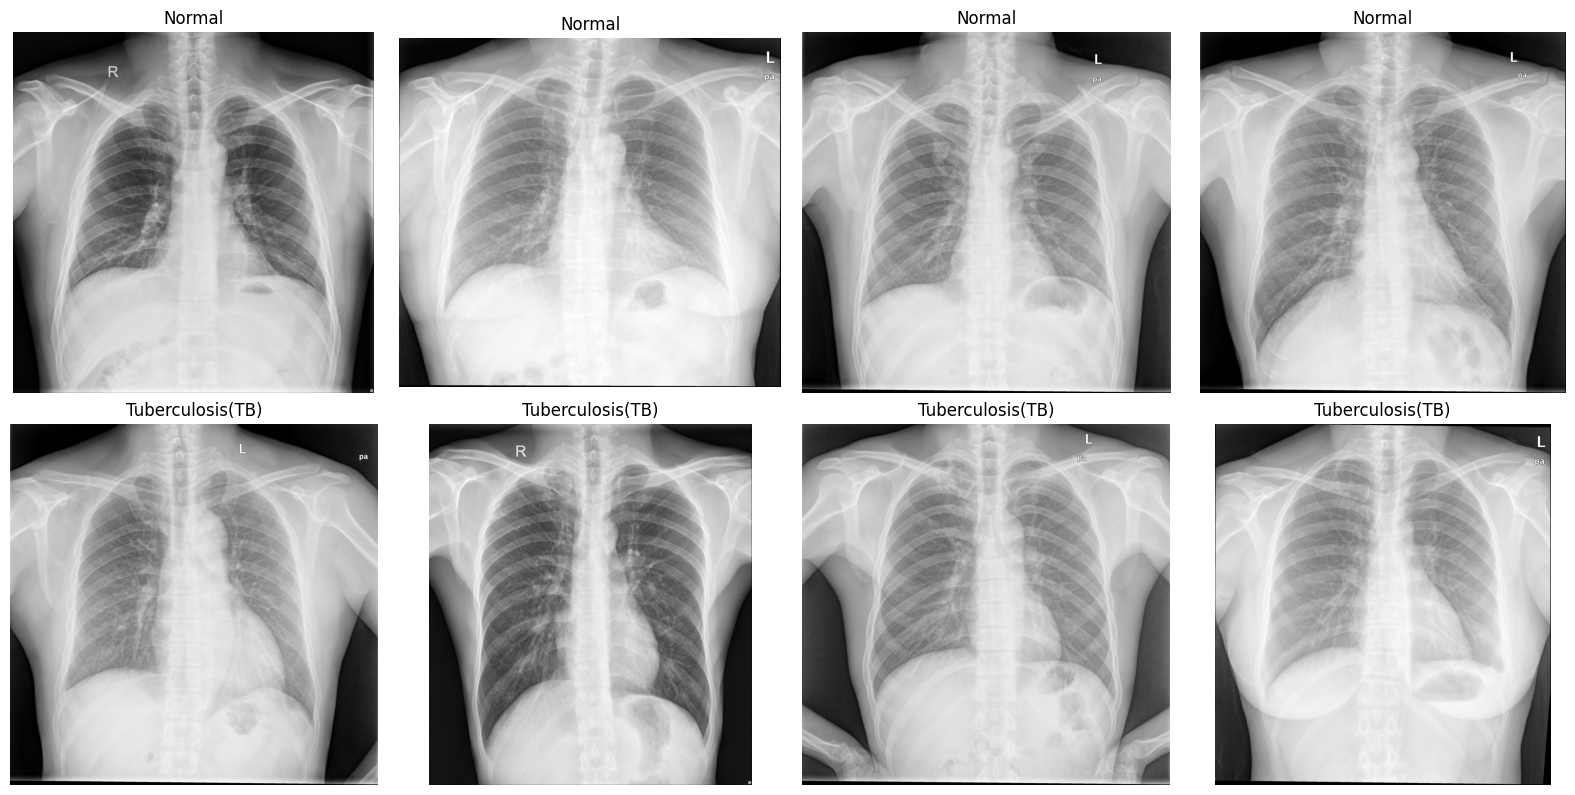

In [12]:
# Shenzen Dataset
image_path = '/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/CXR_png/'
show_random_images(df_shen,'Label',4, image_path)

# 2. Image Processing

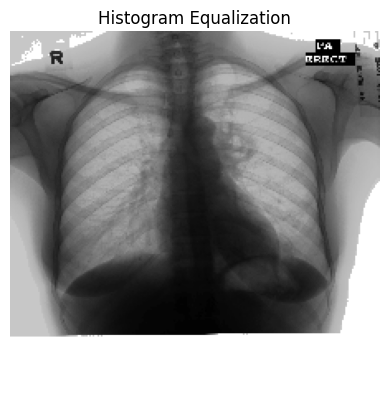

In [13]:
img = cv2.imread('/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Montgomery_Set/Montgomery_Set/CXR_png/MCUCXR_0142_1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (224, 224))
negative = 255 - resized
neg_hist_eq = cv2.equalizeHist(negative)

plt.imshow(neg_hist_eq , cmap='gray')
plt.title("Histogram Equalization")
plt.axis('off')
plt.show()

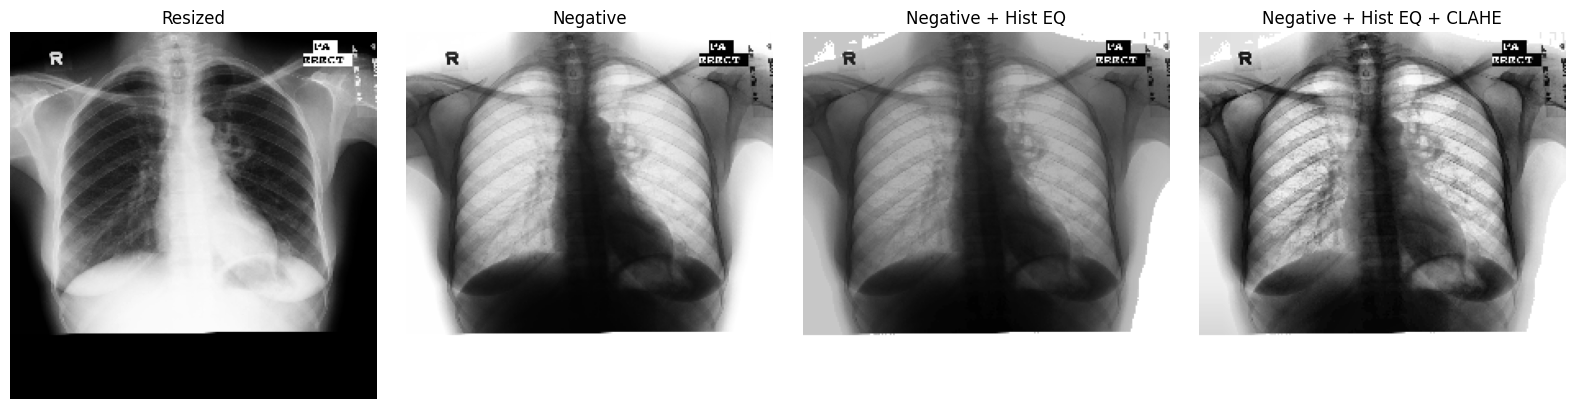

In [14]:
img = cv2.imread('/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Montgomery_Set/Montgomery_Set/CXR_png/MCUCXR_0142_1.png')

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Resize
resized = cv2.resize(gray, (224, 224))
# Negative
negative = 255 - resized
# Histogram Equalization
neg_hist_eq = cv2.equalizeHist(negative)
# Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
adaptive_hist = clahe.apply(neg_hist_eq)  

images = [resized, negative, neg_hist_eq, adaptive_hist]
titles = ['Resized', 'Negative', 'Negative + Hist EQ', 'Negative + Hist EQ + CLAHE']

plt.figure(figsize=(16,4))
for i, (img_show, title) in enumerate(zip(images, titles)):
    plt.subplot(1,4,i+1)
    plt.imshow(img_show, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [15]:
def preprocess_image(df, imagePath, savePath, size=(224,224), clipLimit=3.0, tileGridSize=(8,8)):
    """
    Preprocess all images in the dataframe and save to disk.
    Steps:
    - Grayscale
    - Resize
    - Negative
    - Histogram Equalization
    - Contrast Limited Adaptive Histogram Equalization (CLAHE)
    """
    os.makedirs(savePath, exist_ok=True)  

    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)

    for row in tqdm(df.itertuples(), total=len(df)):
        filePath = os.path.join(imagePath, row.image_id)
        img = cv2.imread(filePath)
        
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize
        resized = cv2.resize(gray, size)
        
        # Negative
        negative = 255 - resized
        
        # Histogram Equalization
        hist_eq = cv2.equalizeHist(negative)
        
        # Contrast Limited Adaptive Histogram Equalization (CLAHE)
        adaptive_hist = clahe.apply(hist_eq)
        
        # Save processed image
        saveFile = os.path.join(savePath, row.image_id)
        cv2.imwrite(saveFile, adaptive_hist)



In [16]:
# Montgomery Dataset
montPath = '/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Montgomery_Set/Montgomery_Set/CXR_png/'
montSavePath = '/kaggle/working/MontgomeryProcessed/'
preprocess_image(df_mont, montPath, montSavePath)

# Shenzhen Dataset
shenPath = '/kaggle/input/chest-x-ray-dataset-montgomery-and-shenzhen/Shenzhen_Set/Shenzhen_Set/CXR_png/'
shenSavePath = '/kaggle/working/ShenzhenProcessed/'
preprocess_image(df_shen, shenPath, shenSavePath)


100%|██████████| 662/662 [01:44<00:00,  6.33it/s]


/tmp/ipykernel_19/4192730750.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f"{image_path}{row['image_id']}")


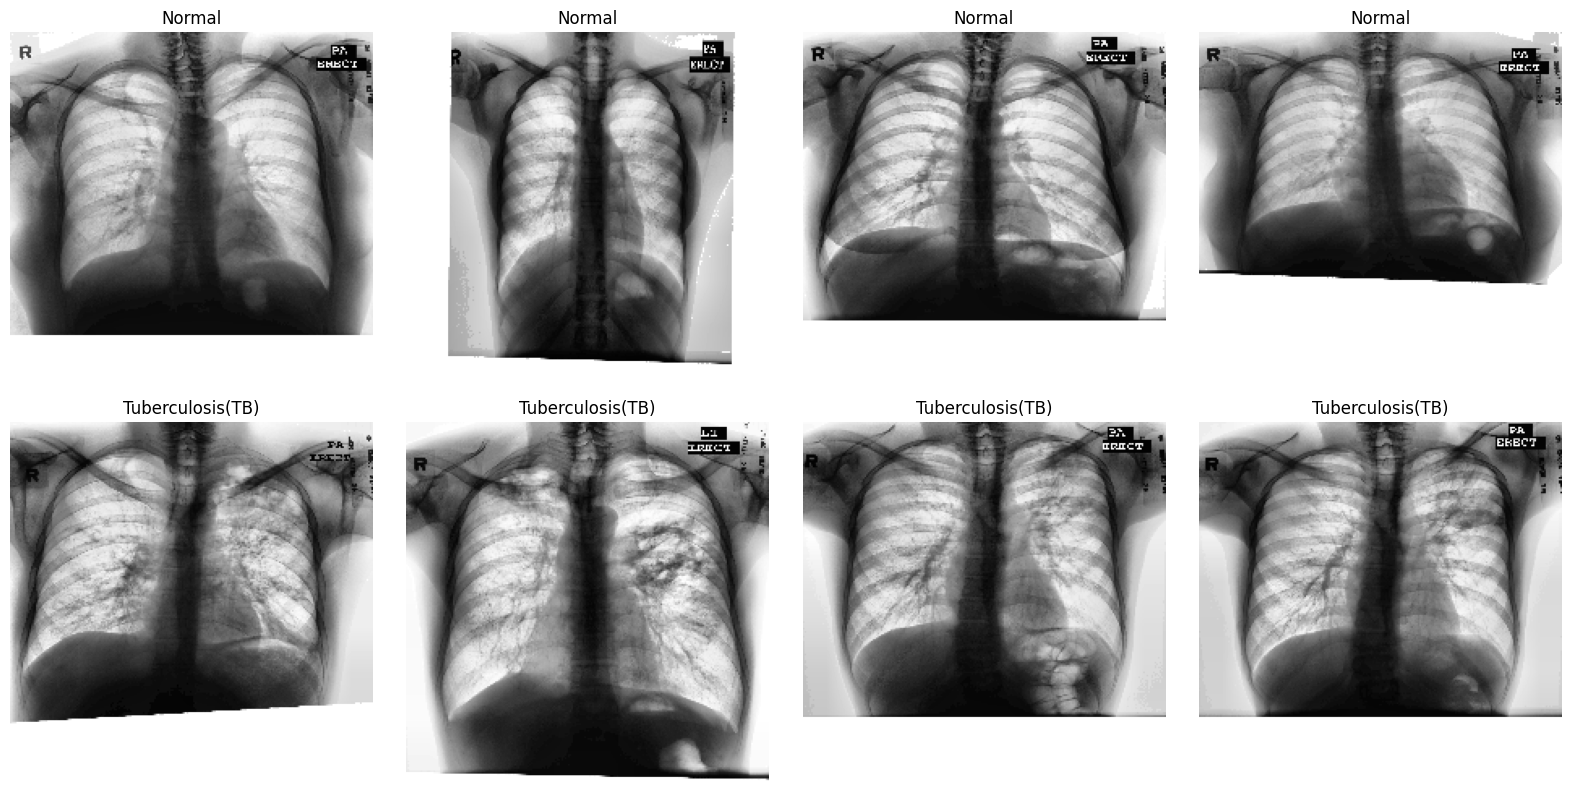

In [17]:
# Montgomery Dataset processed

image_path = '/kaggle/working/MontgomeryProcessed/'
show_random_images(df_mont, 'Label', 4, image_path)

/tmp/ipykernel_19/4192730750.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f"{image_path}{row['image_id']}")


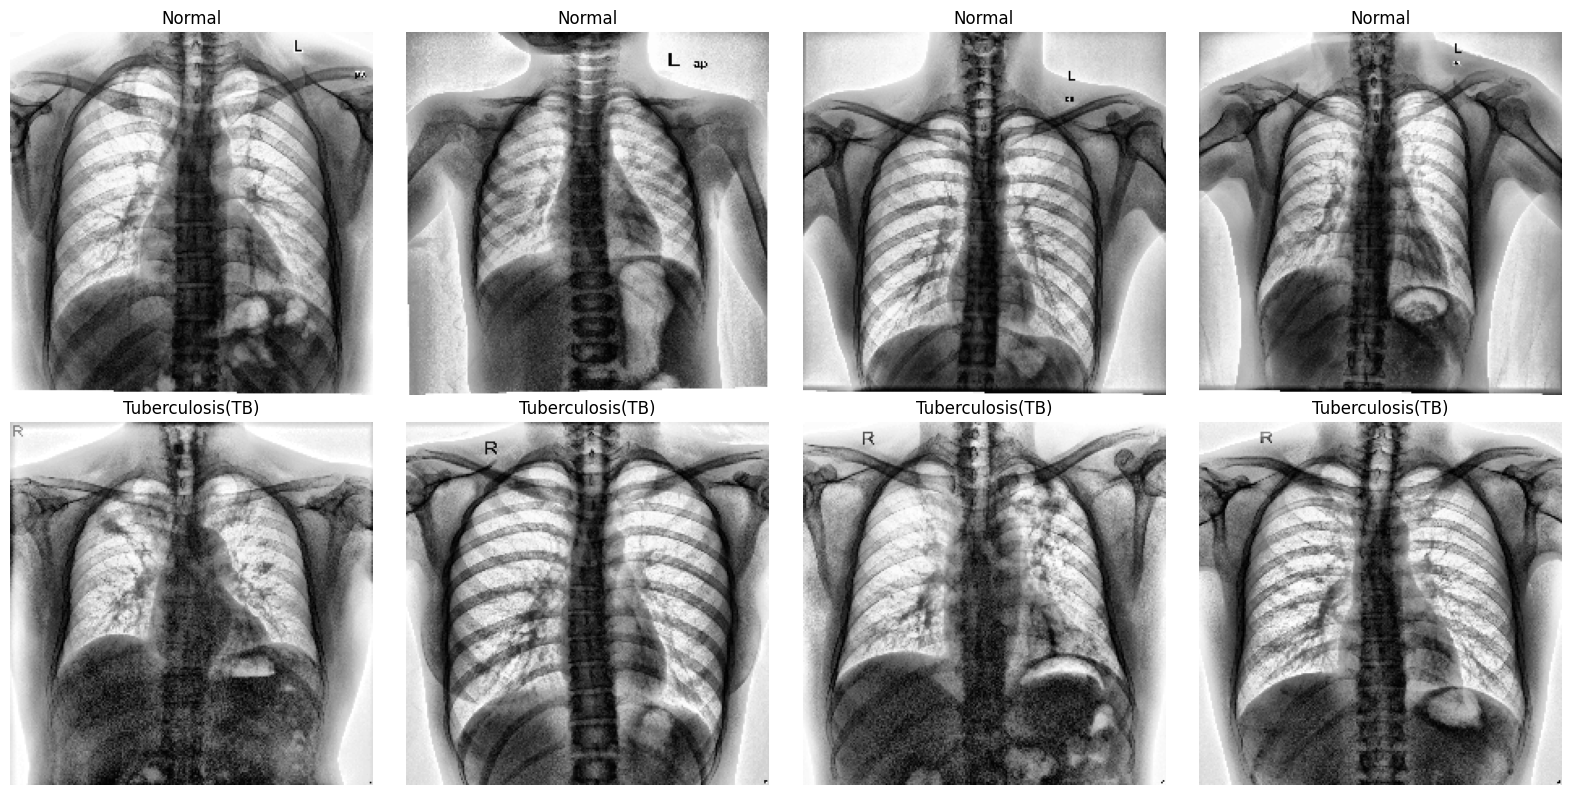

In [18]:
# Shenzhen Dataset processed

image_path = '/kaggle/working/ShenzhenProcessed/'
show_random_images(df_shen, 'Label', 4, image_path)

In [19]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 2)

In [20]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['Class'] = df_data['Label'].map({'Normal':0, 'Tuberculosis(TB)':1})

In [21]:
df_data

image_id             Label  Class
219  CHNCXR_0249_0.png            Normal      0
647  CHNCXR_0392_1.png  Tuberculosis(TB)      1
689  MCUCXR_0367_1.png  Tuberculosis(TB)      1
391  CHNCXR_0430_1.png  Tuberculosis(TB)      1
36   CHNCXR_0280_0.png            Normal      0
..                 ...               ...    ...
795  MCUCXR_0060_0.png            Normal      0
121  CHNCXR_0495_1.png  Tuberculosis(TB)      1
325  CHNCXR_0124_0.png            Normal      0
125  CHNCXR_0428_1.png  Tuberculosis(TB)      1
640  CHNCXR_0293_0.png            Normal      0

[800 rows x 3 columns]

In [22]:
# train_test_split

y = df_data['Class']

df_train, df_val = train_test_split(df_data, test_size=0.3, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(560, 3)
(240, 3)


In [23]:
df_train['Label'].value_counts()

Label
Normal              284
Tuberculosis(TB)    276
Name: count, dtype: int64

In [24]:
df_val['Label'].value_counts()

Label
Normal              122
Tuberculosis(TB)    118
Name: count, dtype: int64

# Model

### 1. Define Transforms

In [25]:
from torchvision import transforms

# Training transform (augmentation for X-ray, only safe ops)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to match CNN input
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # contrast 
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])  # For pretrained CNN
])

# Validation / Test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


### 2. Dataset Class

In [26]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

class CXRDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images (Montgomery + Shenzhen)
    - No horizontal flip because flipping X-ray can mislead anatomy
    - Images are converted to 3 channels for pretrained CNN
    """
    def __init__(self, df, mont_path, shen_path, transform=None):
        self.df = df.reset_index(drop=True)  # Reset index
        self.mont_path = mont_path
        self.shen_path = shen_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'image_id']  # Image file name
        label = self.df.loc[idx, 'Class']        # 0=Normal, 1=TB

        # Determine which folder the image is in
        if img_name in os.listdir(self.mont_path):
            img_path = os.path.join(self.mont_path, img_name)
        else:
            img_path = os.path.join(self.shen_path, img_name)

        # Open image as grayscale
        image = Image.open(img_path).convert('L')

        # Duplicate grayscale channel to 3 channels for pretrained CNN
        image = np.array(image)
        image = np.stack([image]*3, axis=-1)  # H x W x 3
        image = Image.fromarray(image)

        # Apply transforms (resize, tensor conversion, normalization)
        if self.transform:
            image = self.transform(image)

        return image, label


### 3. Create DataLoader

In [27]:

from torch.utils.data import DataLoader

mont_path = '/kaggle/working/MontgomeryProcessed'
shen_path = '/kaggle/working/ShenzhenProcessed'

train_dataset = CXRDataset(df_train, mont_path, shen_path, transform=train_transform)
val_dataset = CXRDataset(df_val, mont_path, shen_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



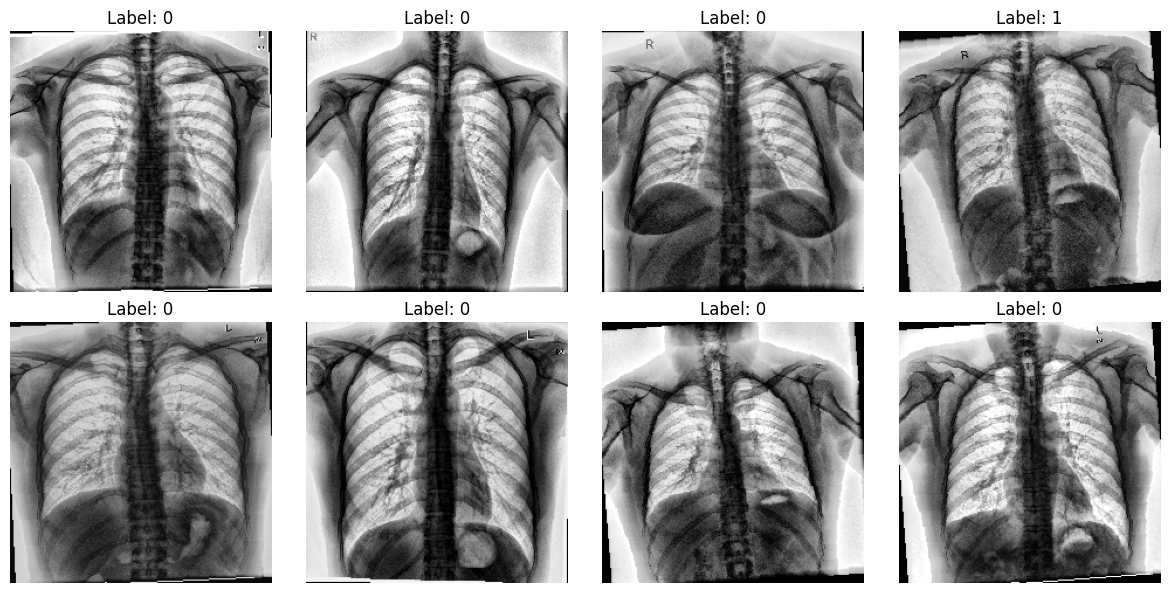

In [28]:
import matplotlib.pyplot as plt
import torchvision

# Get one batch from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalize function (undo normalization for visualization)
def denormalize(img):
    img = img.numpy().transpose((1,2,0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean   # reverse normalization
    img = np.clip(img, 0, 1)
    return img

# Show 8 augmented images
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = denormalize(images[i].cpu())
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


### 4. Model Architecture (Pretrained CNN Models : pretrained EfficientNet-B1)

In [29]:
# import torch
# import torch.nn as nn
# from torchvision import models

# # Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load pretrained ResNet18
# model = models.resnet18(pretrained=True)

# # Replace the final fully connected layer for binary classification
# num_ftrs = model.fc.in_features  # Get input features of last layer
# model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Normal / TB

# # Move model to GPU if available
# model = model.to(device)

# print(model)


In [30]:
import torch
import torch.nn as nn
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet-B1
model = models.efficientnet_b1(pretrained=True)

# Freeze backbone initially
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier with hidden layer + ReLU + Dropout
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 classes: Normal / TB
)

# Move model to device
model = model.to(device)

print(model)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 137MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

 ## 5. Train model

In [31]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 100

# Training stats
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):   #  Loop multiple epochs

    # Training
    model.train()
    total_train_loss = 0.0

    for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)  # multiply by batch size

    # Validation
    model.eval()

    # calculate accuracy
    total_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item() * inputs.size(0)

            # calculate accuracy
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / len(val_dataset)

# collect train history
    train_losses.append(total_train_loss / len(train_dataset))
    val_losses.append(total_val_loss / len(val_dataset))
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss = {train_losses[-1]:.4f}")
    print(f"Val   Loss = {val_losses[-1]:.4f}")
    print(f"Val   Acc  = {val_accuracies[-1]:.2f}%")
            

# Early Stopping setup

patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):

    val_loss = total_val_loss / len(val_dataset)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # reset counter
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break



Epoch 1
Train Loss = 0.7002
Val   Loss = 0.6924
Val   Acc  = 50.83%

Epoch 2
Train Loss = 0.6908
Val   Loss = 0.6895
Val   Acc  = 57.92%

Epoch 3
Train Loss = 0.6856
Val   Loss = 0.6812
Val   Acc  = 57.92%

Epoch 4
Train Loss = 0.6870
Val   Loss = 0.6751
Val   Acc  = 64.17%

Epoch 5
Train Loss = 0.6733
Val   Loss = 0.6720
Val   Acc  = 64.17%

Epoch 6
Train Loss = 0.6675
Val   Loss = 0.6692
Val   Acc  = 65.83%

Epoch 7
Train Loss = 0.6670
Val   Loss = 0.6644
Val   Acc  = 67.50%

Epoch 8
Train Loss = 0.6687
Val   Loss = 0.6607
Val   Acc  = 67.50%

Epoch 9
Train Loss = 0.6554
Val   Loss = 0.6571
Val   Acc  = 69.17%

Epoch 10
Train Loss = 0.6557
Val   Loss = 0.6529
Val   Acc  = 69.17%

Epoch 11
Train Loss = 0.6525
Val   Loss = 0.6492
Val   Acc  = 71.25%

Epoch 12
Train Loss = 0.6503
Val   Loss = 0.6450
Val   Acc  = 71.25%

Epoch 13
Train Loss = 0.6443
Val   Loss = 0.6409
Val   Acc  = 72.50%

Epoch 14
Train Loss = 0.6412
Val   Loss = 0.6377
Val   Acc  = 72.50%

Epoch 15
Train Loss = 0.6454

## 6. Plot chart

In [32]:

import plotly.graph_objects as go

epochs = list(range(1, num_epochs + 1))
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=train_losses, mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(x=epochs, y=val_losses, mode='lines+markers', name='Val Loss'))
fig.add_trace(go.Scatter(x=epochs, y=val_accuracies, mode='lines+markers', name='Val Accuracy', yaxis='y2'))
fig.update_layout(title='Training & Validation Metrics', xaxis_title='Epoch', yaxis=dict(title='Loss'), yaxis2=dict(title='Accuracy (%)', overlaying='y', side='right'), legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center'), width=800, height=500)
fig.show()


## 7. Evaluation metrics

Validation Accuracy: 0.7625
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       122
           1       0.81      0.68      0.74       118

    accuracy                           0.76       240
   macro avg       0.77      0.76      0.76       240
weighted avg       0.77      0.76      0.76       240



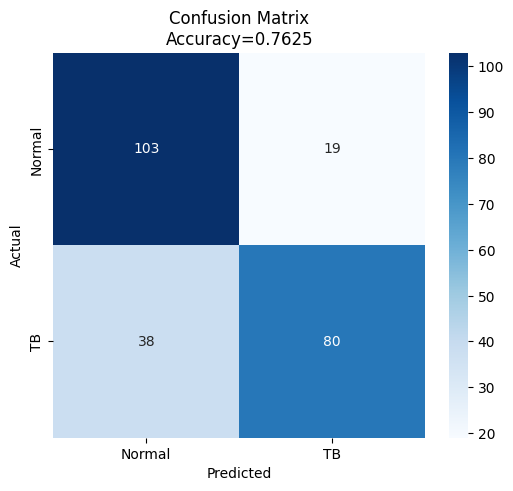

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set model to evaluation

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Compute metrics

acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:\n", report)


# Plot confusion matrix

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','TB'], yticklabels=['Normal','TB'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy={acc:.4f}')
plt.show()



## Metrics Formulas

- **Sensitivity / Recall / True Positive Rate (TPR)**:  
$$
\text{Sensitivity (TPR)} = \frac{TP}{TP + FN}
$$

- **Specificity / True Negative Rate (TNR)**:  
$$
\text{Specificity (TNR)} = \frac{TN}{TN + FP}
$$

- **Positive Predictive Value (PPV)**:  
$$
\text{PPV} = \frac{TP}{TP + FP}
$$

- **Negative Predictive Value (NPV)**:  
$$
\text{NPV} = \frac{TN}{TN + FN}
$$



In [34]:
TN, FP, FN, TP = cm.ravel()  

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print(f"Sensitivity (Recall, TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"Positive Predictive Value (PPV): {ppv:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")


Sensitivity (Recall, TPR): 0.6780
Specificity (TNR): 0.8443
Positive Predictive Value (PPV): 0.8081
Negative Predictive Value (NPV): 0.7305


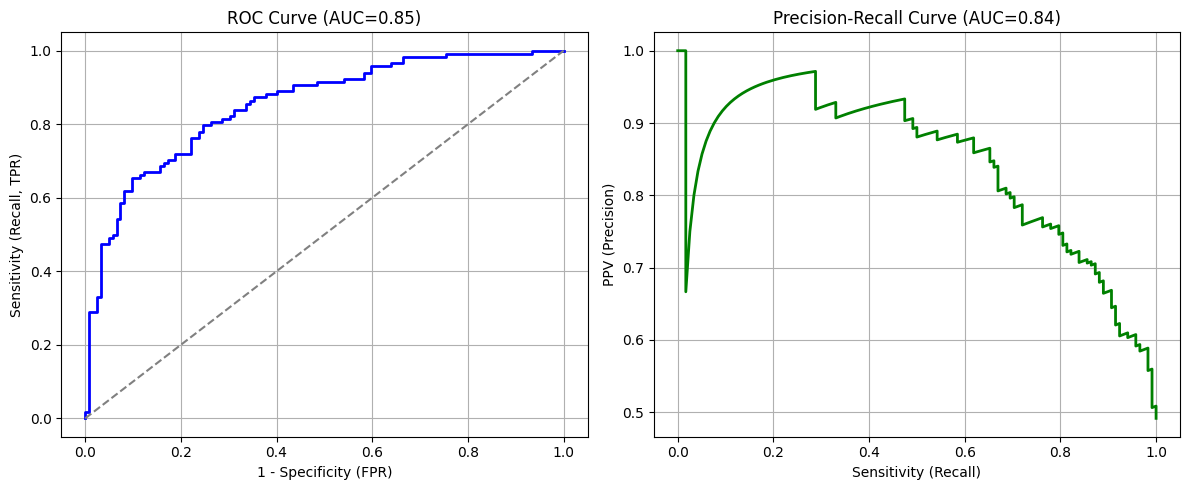

In [35]:
import torch
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

#  model outputs (logits) from val_loader
all_probs = []  # probability of TB class
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:,1]  # probability of TB class
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot subplot
fig, axes = plt.subplots(1,2, figsize=(12,5))

# Sensitivity (Recall) vs 1-Specificity
axes[0].plot(fpr, tpr, color='blue', lw=2)
axes[0].plot([0,1],[0,1], color='grey', linestyle='--')
axes[0].set_xlabel('1 - Specificity (FPR)')
axes[0].set_ylabel('Sensitivity (Recall, TPR)')
axes[0].set_title(f'ROC Curve (AUC={roc_auc:.2f})')
axes[0].grid(True)

# PPV (Precision) vs Sensitivity (Recall)
axes[1].plot(recall, precision, color='green', lw=2)
axes[1].set_xlabel('Sensitivity (Recall)')
axes[1].set_ylabel('PPV (Precision)')
axes[1].set_title(f'Precision-Recall Curve (AUC={pr_auc:.2f})')
axes[1].grid(True)

plt.tight_layout()
plt.show()


##  8. Save and load model
- `.pth` save only model weights
- `.pt` save entire model

#### Save model state_dict

In [36]:
torch.save(model.state_dict(), "model_EfficientNet-B1_weights.pth")  # only weights

In [37]:
import torch
from torchvision import models
import torch.nn as nn


new_model = models.efficientnet_b1(pretrained=False)

num_ftrs = new_model.classifier[1].in_features

new_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 classes: Normal / TB
)

new_model.load_state_dict(torch.load("model_EfficientNet-B1_weights.pth"))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



<All keys matched successfully>

#### Save entire model

In [38]:
torch.save(model, "full_model_EfficientNet-B1.pt")

In [39]:
import torch

New_model2 = torch.load("full_model_EfficientNet-B1.pt" , weights_only=False)

New_model2.eval()  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
New_model2 = New_model2.to(device)


In [40]:
New_model2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 9. For Finetune Models (Optional)

In [41]:
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.optim as optim

# class Trainer:
#     def __init__(self, model, train_loader, val_loader, n_val, lr=1e-5, epochs=5, device='cpu'):
#         self.model = model.to(device)
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.n_val = n_val
#         self.epochs = epochs
#         self.lr = lr
#         self.device = device
#         self.loss_fn = nn.CrossEntropyLoss()
#         self.optimizer = optim.Adam(model.parameters(), lr=lr)
#         self.train_losses = []
#         self.val_losses = []
#         self.val_accuracies = []

#     def train(self):
#         for epoch in range(self.epochs):
#             # Training
#             self.model.train()
#             total_train_loss = 0
#             train_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs} [Train]", leave=False)
#             for inputs, labels in train_bar:
#                 inputs, labels = inputs.to(self.device), labels.to(self.device)
#                 self.optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = self.loss_fn(outputs, labels)
#                 loss.backward()
#                 self.optimizer.step()
#                 total_train_loss += loss.item() * inputs.size(0)
#                 train_bar.set_postfix(loss=loss.item())

#             self.train_losses.append(total_train_loss / len(self.train_loader.dataset))

#             # Validation
#             self.model.eval()
#             total_val_loss = 0
#             correct = 0
#             val_bar = tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{self.epochs} [Val]", leave=False)
#             with torch.no_grad():
#                 for inputs, labels in val_bar:
#                     inputs, labels = inputs.to(self.device), labels.to(self.device)
#                     outputs = self.model(inputs)
#                     loss = self.loss_fn(outputs, labels)
#                     total_val_loss += loss.item() * inputs.size(0)
#                     preds = outputs.argmax(dim=1)
#                     correct += (preds == labels).sum().item()
#                     val_bar.set_postfix(loss=loss.item())

#             self.val_losses.append(total_val_loss / len(self.val_loader.dataset))
#             self.val_accuracies.append(100*correct/self.n_val)

#             print(f"Epoch {epoch+1}: Train Loss={self.train_losses[-1]:.4f}, "
#                   f"Val Loss={self.val_losses[-1]:.4f}, Val Acc={self.val_accuracies[-1]:.2f}%")

#     def plot_history(self):
#         import plotly.graph_objects as go
    
#         epochs = list(range(1, len(self.train_losses) + 1))
#         fig = go.Figure()
    
#         # Train Loss
#         fig.add_trace(go.Scatter(
#             x=epochs, y=self.train_losses,
#             mode='lines+markers', name='Train Loss'
#         ))
    
#         # Validation Loss
#         fig.add_trace(go.Scatter(
#             x=epochs, y=self.val_losses,
#             mode='lines+markers', name='Val Loss'
#         ))
    
#         # Validation Accuracy (secondary y-axis)
#         fig.add_trace(go.Scatter(
#             x=epochs, y=self.val_accuracies,
#             mode='lines+markers', name='Val Accuracy',
#             yaxis='y2'
#         ))
    
#         # Layout
#         fig.update_layout(
#             title='Training & Validation Metrics',
#             xaxis_title='Epoch',
#             yaxis=dict(title='Loss'),
#             yaxis2=dict(title='Accuracy (%)', overlaying='y', side='right'),
#             legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center'),
#             width=800, height=500
#         )
    
#         fig.show()


In [42]:
# trainer = Trainer(New_model2, train_loader, val_loader, n_val=len(val_dataset), lr=0.00001, epochs=20)
# trainer.train()
# trainer.plot_history()